In [2]:
import pandas as pd
import numpy as np
import os 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.utils as utils
import torch.optim as optim

import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import confusion_matrix

8 Class classification problem 

Initially work on trying to classifiy based on google search scraped pictures of these lightbulbs.
The problem with this is that they nearly always have a white backgroud and are not realistic of a phone camera version
of a picture of the light bulb
'current search: B15 light bulbs'

Classes
E27 light bulbs
E14 light bulbs
B22 light bulbs
B15 light bulbs
GU10 light bulbs
G4
G9
MR16


Need to also buy some examples of the light bulbs as a way of building up my own dataset that might be more realistic.


# Support functions

In [3]:
folders = ['B15','B22','E14', 'E27', 'G4', 'G9','GU10', 'MR16']

def file_rename(folders):
    '''
    Function to rename all files taken from the internet from training.Used to rename
    all the file names to avoid really long file names and make it easier to know which
    bulb it is.
    
    Could be made more generic for other projects. Eg move out the base location into a parameter.
    
    input - folder names
    
    output - all files renamed in place. 
    
    '''
    
    for bulb_type in folders:

        location = r"C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data"
        location = location + '\\' + bulb_type + '\\'
        print(location)
        for count, filename in enumerate(os.listdir(location)): 
            dst = bulb_type + str(count) + ".jpg"
            src = location + filename 
            dst = location + dst 
            # rename() function will 
            # rename all the files 
            os.rename(src, dst) 

In [4]:
def create_separate_train_dev_test( dataset, percentages = [0.8,0.1,0.1]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    # Add in test to check for this ~
    
    Outputs - each dataloader.
    
    '''

    indices = list(range(len(light_bulbs)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(light_bulbs)*0.8))
    split_2 = int(np.floor(len(light_bulbs)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(light_bulbs,
                                                 batch_size=64,
                                                 num_workers=0 , sampler = train_sampler)

    dataloader_dev = torch.utils.data.DataLoader(light_bulbs,
                                                 batch_size=1,
                                                 num_workers=0 , sampler = dev_sampler)

    dataloader_test = torch.utils.data.DataLoader(light_bulbs,
                                                 batch_size=1,
                                                 num_workers=0 , sampler = test_sampler)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [5]:
def print_examples(dataloader, number_to_show =4):
    i=0
    for x, y in dataloader:  
        out = np.reshape(x[i].numpy(),newshape =[x[i].shape[1],x[i].shape[2],x[i].shape[0]])
        plt.imshow(out)
        plt.title('Bulb type {}'.format(y[i]))
        plt.show()
        
        i = i + 1
        if i == number_to_show:
            break

# Datasets

In [6]:
# Create a pytorch dataset, and then dataloader to allow for mini-batch processing. 
data_transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(128),
        #transforms.RandomSizedCrop(256),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
    
light_bulbs = datasets.ImageFolder(root=r'C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data',
                                           transform=data_transform)
    

In [7]:
train, dev, test = create_separate_train_dev_test(light_bulbs, percentages = [0.8,0.1,0.1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


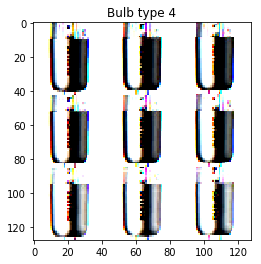

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


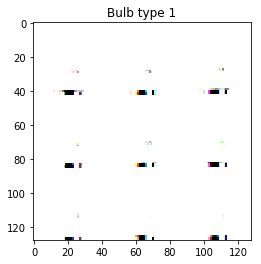

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


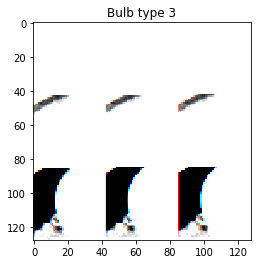

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


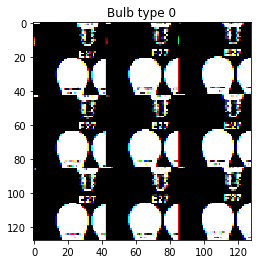

In [8]:
print_examples(train, number_to_show =4)

# CNN

In [9]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
# Define the classifier

class bulb_model(nn.Module):
    
    def __init__(self):
        super(bulb_model, self).__init__()
    
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            # add a max pooling layer
            nn.MaxPool2d(kernel_size =3 , stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            nn.MaxPool2d(kernel_size =2 , stride=1, padding=0),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(512, 10, 4, 1, 0, bias = False), 
            nn.Flatten(),
            nn.Linear(160, 512),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10),
            nn.Softmax()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [11]:
classifier_1 = bulb_model()
classifier_1.apply(weights_init)

bulb_model(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Leaky

# Train classifier

In [12]:
# create an optimiser for the classifier
optimiser_bulb = optim.Adam(classifier_1.parameters(), lr=0.002, betas = (0.9,0.999))
# Create a criterion. Lets use cross entropy loss. 
criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

In [13]:
epochs_total = 1

In [14]:
for epoch in range(epochs_total):
    i = 1
    for data, labels in train:
     
        # push the image through the network
        prediction = classifier_1(data)
        
        error = criterion(prediction, labels)
        print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
  
        # zero grad
        classifier_1.zero_grad()
        error.backward()
        optimiser_bulb.step()
        
        #if i == 10:
        #   break
            
        i = i + 1

C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[0/1][1/57] Loss: 2.2989
[0/1][2/57] Loss: 2.3107
[0/1][3/57] Loss: 2.2541
[0/1][4/57] Loss: 2.2842
[0/1][5/57] Loss: 2.3156
[0/1][6/57] Loss: 2.2392
[0/1][7/57] Loss: 2.3133
[0/1][8/57] Loss: 2.3375
[0/1][9/57] Loss: 2.2191
[0/1][10/57] Loss: 2.3048
[0/1][11/57] Loss: 2.3255
[0/1][12/57] Loss: 2.3016
[0/1][13/57] Loss: 2.2588
[0/1][14/57] Loss: 2.2766
[0/1][15/57] Loss: 2.2685


C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0/1][16/57] Loss: 2.3674
[0/1][17/57] Loss: 2.2883
[0/1][18/57] Loss: 2.3200
[0/1][19/57] Loss: 2.3205
[0/1][20/57] Loss: 2.2737
[0/1][21/57] Loss: 2.2422
[0/1][22/57] Loss: 2.2573
[0/1][23/57] Loss: 2.3204
[0/1][24/57] Loss: 2.2111
[0/1][25/57] Loss: 2.3205
[0/1][26/57] Loss: 2.3197
[0/1][27/57] Loss: 2.2580
[0/1][28/57] Loss: 2.3048
[0/1][29/57] Loss: 2.2727
[0/1][30/57] Loss: 2.3044
[0/1][31/57] Loss: 2.2730
[0/1][32/57] Loss: 2.1647
[0/1][33/57] Loss: 2.2731
[0/1][34/57] Loss: 2.2572
[0/1][35/57] Loss: 2.3054
[0/1][36/57] Loss: 2.3358
[0/1][37/57] Loss: 2.3198
[0/1][38/57] Loss: 2.3827
[0/1][39/57] Loss: 2.3354
[0/1][40/57] Loss: 2.3357
[0/1][41/57] Loss: 2.3043
[0/1][42/57] Loss: 2.2892
[0/1][43/57] Loss: 2.3043
[0/1][44/57] Loss: 2.3987
[0/1][45/57] Loss: 2.3816
[0/1][46/57] Loss: 2.3518
[0/1][47/57] Loss: 2.3362
[0/1][48/57] Loss: 2.3674
[0/1][49/57] Loss: 2.3518
[0/1][50/57] Loss: 2.3518
[0/1][51/57] Loss: 2.3518
[0/1][52/57] Loss: 2.3830
[0/1][53/57] Loss: 2.3201
[0/1][54/57]

In [60]:
# confusion matrix on the dev set
# F1 score - going to be my key metric? (for now)

def inference(model, dev_dataset):

    dev_predictions = []
    dev_labels = []

    for data, labels in dev_dataset:
            # push the image through the network
            predictions = model(data).detach().numpy()
            #print(predictions)
            index  = np.argmax(predictions, axis=1)
            #print(index)
            dev_predictions.append(index)
            actual = labels.detach().numpy()
            dev_labels.append(actual)

    print(confusion_matrix(dev_labels, dev_predictions))

    from sklearn.metrics import precision_score, recall_score
    pre = precision_score(dev_labels, dev_predictions, average='micro')
    print('Precision {}'.format(round(pre,3)))
    rec = recall_score(dev_labels, dev_predictions, average='micro')
    print('Recall {}'.format(round(rec,3)))

In [61]:
inference(classifier_1, dev)

C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[[ 0  0 12  0  0  1  0 37]
 [ 0  0 11  0  0  0  0 32]
 [ 0  0 18  0  0  0  0 32]
 [ 0  0 17  0  0  0  0 35]
 [ 2  0 26  0  0  0  0 47]
 [ 1  0 19  0  0  0  0 33]
 [ 1  0  9  0  0  1  0 35]
 [ 1  0 15  0  0  2  0 62]]
Precision 0.178
Recall 0.178


# Experimenting with Built from Scratch

Base set up - after 25 epochs it predicts them all to be type 3.

What's the problem - high bias

Bigger network,
change the learning rate
change the layers



# Transfer Learning

In [18]:
# To try and give myself a heads start lets see what happens if we use VGG network as the basis and then transfer learn. 

In [69]:
'''
Create a way to train more layers is required. 
For now all  37 original layers not retrained.
I think I would need to retrain for this problem
but it quickly increases the parameters required. 
'''
def retrainable_setup(model ,layers_limit):

    '''
    Function that allows you to set certain layers to be trainable or not
    When using a transfer learning approach can vary the amount of layers you want to retrain.
    
    input 
    - layers_limit - number of layers to keep fixed.
    - model 
    
    output 
    - model - with layers set for training or not. 
    '''

    for param in model.parameters():
        param.requires_grad = False
    i = 0
    for child in model.children():
        for layer in child.children():
            i  +=1
            if i > layers_limit:
                for param in layer.parameters():
                    param.requires_grad = True
            else:
                for param in layer.parameters():
                    param.requires_grad = False


In [70]:
from torchvision import models
modelVGG = models.vgg16(pretrained=True)

In [74]:
modelVGG.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 8),                   
                      nn.Softmax(dim=1))

In [75]:
retrainable_setup(model ,layers_limit = 33)

In [76]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,432 total parameters.
17,832,200 training parameters.


In [ ]:
epochs_total = 25
for epoch in range(epochs_total):
    i = 1
    for data, labels in train:
     
        # push the image through the network
        prediction = model(data)
        
        error = criterion(prediction, labels)
        print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
  
        # zero grad
        model.zero_grad()
        error.backward()
        optimiser_bulb.step()
        
        #if i == 10:
        #   break
            
        i = i + 1

In [78]:
inference(model, dev)

[[ 4  9  7 24  0  2  4  0]
 [10  4  4 16  2  2  2  3]
 [ 6  6  4 28  1  1  4  0]
 [ 6  9  8 20  0  0  9  0]
 [ 2 14  8 44  0  2  4  1]
 [ 3  8  3 35  0  2  2  0]
 [ 6  4  5 26  2  0  3  0]
 [ 9 16  7 37  4  2  5  0]]
Precision 0.082
Recall 0.082
